# Fitting the Winterwerp (1998) model to data

**Summary:** This worksheet can be used to find the $K_{a}^{'}$ and $K_{b}^{'}$ values in the Winterwerp 1998 model (W98) that produce the closest fit to observed time series data of floc size.

The W98 model is an ODE which defines the rate change in floc size, $dD/dt$, as being equal to the rate of aggregation, $A$, minus the rate of breakup, $B$. These aggregation and breakup rates are a function of many inputs parameters such as the rate of turbulent shearing, $G$, the suspended sediment concentration, $C$, and the properties of the floc and sediment such as the density of the sediment, the fractal dimension of the flocs, and the yield strength of the floc. In addition to these inputs, the W98 model makes use of aggregation and breakup efficiency parameters $K_{a}^{'}$ and $K_{b}^{'}$. These are purely empirical parameters that pertain to the “stickiness” of the sediment and the ion and organic content and concentration in the water. To find out more about the W98 model, read the original paper (below) and/or see the [Winterwerp1998-Model](https://github.com/FlocData/Floc-Analysis/blob/master/Winterwerp1998-Model.ipynb) notebook.

References:
Winterwerp, J. C. (1998). A simple model for turbulence induced flocculation of cohesive sediment. Journal of Hydraulic Research, 36(3):309–326. http://dx.doi.org/10.1080/00221689809498621

## Load the needed packages

In [7]:
%pylab inline
import numpy as np
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Load and plot the floc time series data

In [8]:
datafile = '03_PS2.csv' # data file to load
subfolder = 'data'      # folder within the working directory that contains the data files
df_ps02 = pd.read_csv(subfolder+'/'+datafile) # read in the data file
df_micron = array(df_ps02['D50_micron']) # extract numpy array from the pandas dataframe
t_min = array(df_ps02['Time_min']) # extract numpy array from the pandas dataframe
df_ps02.head() # displays the first few rows of data

,Time_min,D16_micron,D50_micron,D84_micron
0,1.0,12.7335,20.6013,39.3249
1,2.0,13.2074,23.8470,45.4082
2,3.0,13.8934,25.3438,65.4272
3,4.0,14.1042,25.6631,49.8698
4,5.0,10.0286,19.1833,36.1036


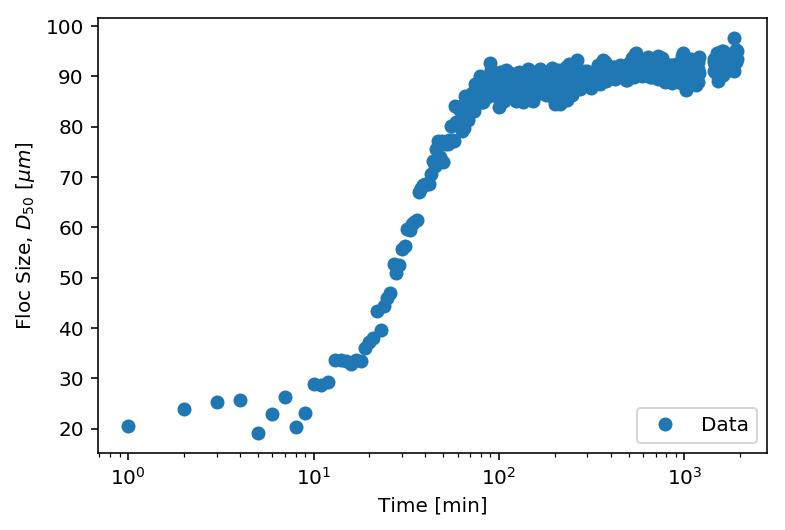

In [9]:
fig, ax = plt.subplots()
ax.plot(t_min,df_micron,'o', label='Data')
ax.set_xscale('log'),
ax.set_xlabel('Time [min]')
ax.set_ylabel('Floc Size, $D_{50}$ [$\mu m$]')
legend(loc=4);

## Fit the W98 Model to the data

The cells below will determine the $K_{a}^{'}$ and $K_{b}^{'}$ parameters in the W98 model that produce the closest match between the model and the experimental data given particular fluid, sediment, and floc input properties. This is done by curve fitting the ODE solution of the W98 model to the data. [Note: if you run into run-time problems with the integration, try adjusting the initial guess conditions for $K_{a}^{'}$ and $K_{b}^{'}$, i.e., `Ka0` and `Kb0`] 

### Define functions such as the W98 model

In [12]:
# The W98 ODE to be integrated: dDdt = A-B
def dDdt(D, t, Ka, Kb): 
    A = Ka*(Dp**(nf-3)/(nf*rhos))*G*C*D**(4-nf) # aggregation term
    B = Kb*((Dp**(-p))/nf)*(mu/Fy)**q*G**(q+1)*(D-Dp)**p*D**(2*q+1) # breakup term
    dDdt = A-B
    return dDdt

# print output definition
def output():
    print('Key inputs')
    print('n_f =', around(nf,decimals=2))
    print('Dp [µm] =', around(Dp*10**6, decimals=0))
    print('Df0 [µm] =', around(D0*10**6, decimals=0))
    print('')
    print('Output: equilibrium floc size')
    print('Dfe [µm] =', around(Dfe*10**6,decimals=0))
    print('')
    print('Output: primed coefficients')
    print('Ka-prime =', around(Ka,decimals=4))
    print('Kb-prime =', Kb)
    print('')
    print('Output: composite coefficients')
    print('Ka =',around(Kacomp,decimals=2))
    print('Kb =',around(Kbcomp,decimals=2))
    print('Ka/Kb = ',around(Kacomp/Kbcomp,decimals=2))

def density(To,Sppt):
    rho_fresh=1000*(1-(To +288.9414)/(508929.2*(To+68.12963))*(To-3.9863)**2)
    Acoef = 0.824493 - 0.0040899*To + 0.000076438*To**2 -0.00000082467*To**3 + 0.0000000053675*To**4
    Bcoef = -0.005724 + 0.00010227*To - 0.0000016546*To**2
    return rho_fresh + Acoef*Sppt + Bcoef*Sppt**(3/2) + 0.00048314*Sppt**2

def visc(To):
    return 2.7488e-07+1.4907e-06*exp(-0.034812*To)

### Fit the model to the data

Key inputs
n_f = 2.5
Dp [µm] = 7.0
Df0 [µm] = 20.0

Output: equilibrium floc size
Dfe [µm] = 94.0

Output: primed coefficients
Ka-prime = 1.4178
Kb-prime = 1.73776561666e-05

Output: composite coefficients
Ka = 0.09
Kb = 8.37
Ka/Kb =  0.01


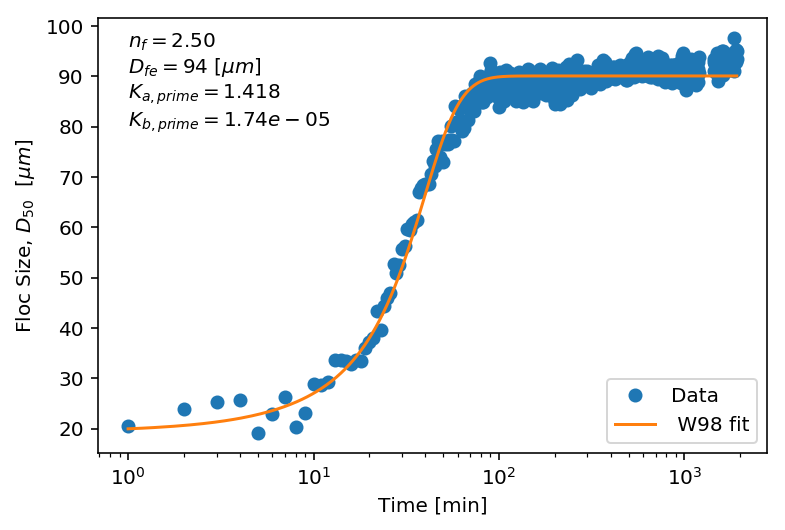

In [16]:
"""
User input --------------------------------------------------------
"""
# Fluid properties 
G = 35.          # turbulent shear rate[s-1]
To = 20          # temperature in degC
Sppt = 0         # salinity in parts per thousand 

# Sediment properties
C = 50/10**3     # suspended sediment concentration [g/L]
Dp = 7/10**6     # primary particle size [m]
Fy = 1e-10       # floc yeild strength [N]
rhos = 2500.     # sediment density [kg/m3]
nf = 2.5         # fractal dimension

# Calculation inputs 
tstart_min = 1   # minute to start the integration at
D0 = 20/10**6    # floc size at tstart_min [m]
Npts = 10000     # number of points in calculation

# initial guess for fit values (change if there are convergence issues) 
Ka0 = 0.5
Kb0 = 5.0e-6

"""
Calculations ----------------------------------------------------
"""
# Pre-integration calcs and array setup
rho = density(To,Sppt)
nu = visc(To)
mu = nu*rho     
p = 3.-nf
q = 0.5

# Setup time array for integration
tend_min = t_min[-1]
t = np.linspace(tstart_min*60,tend_min*60,Npts)

# Solution to the ODE D'(t) = dDdt(D, t, Ka, Kb) with initial condition D(0) = D0
def D(t, Ka0, Kb0): 
    D = odeint(dDdt, D0, t, args=(Ka0, Kb0))
    return D.ravel()

# Setup the data for the comparison
df = df_micron/10**6
t_sec = t_min*60

# Curve fit the solution of the ODE to the data
popt, cov = curve_fit(D, t_sec, df, [Ka0,Kb0])

# asign values to the coefficients
Ka, Kb = popt                           # the primed terms in W98
Kacomp = Ka*(Dp**(nf-3)/(nf*rhos))      # unprimed composite aggregation coef
Kbcomp = Kb*((Dp**(-p))/nf)*(mu/Fy)**q  # unprimed composite breakup coef
Dfe = Dp+Kacomp*C/(Kbcomp*sqrt(G))    # equilibrium model floc size in [m]

# Plot and print the results
fig, ax = plt.subplots()
ax.plot(t_min,df_micron,'o', label='Data')
ax.plot(t/60,D(t, Ka, Kb)*10**6, label=' W98 fit')
ax.set_xscale('log'),
ax.set_xlabel('Time [min]')
ax.set_ylabel('Floc Size, $D_{50}$  [$\mu m$]')
legend(loc=4)

results ='$n_f=%.2f$\n$D_{fe}=%.0f$ $[µm]$\n$K_{a,prime}=%.3f$\n$K_{b,prime}=%1.2e$'%(nf,Dfe*10**6,Ka,Kb)
ax.text(t[0]/60,0.85*Dfe*10**6,results)

output();